In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from pandas.api.types import is_string_dtype, is_numeric_dtype
from scipy.stats import norm
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import random
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
binary_df_filtered = pd.read_csv("data/binary_df_filtered.csv", encoding='latin-1')
binary_df_filtered

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,target
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,Negative emotion,1.0
1,jessedee know fludapp awesome ipad iphone app ...,Positive emotion,0.0
2,swonderlin wait ipad 2 also sale sxsw,Positive emotion,0.0
3,sxsw hope years festival isnt crashy years iph...,Negative emotion,1.0
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive emotion,0.0
...,...,...,...
3543,mention pr guy convinced switch back iphone gr...,Positive emotion,0.0
3544,quotpapyrussort like ipadquot nice lol sxsw la...,Positive emotion,0.0
3545,diller says google tv quotmight run playstatio...,Negative emotion,1.0
3546,ive always used camera iphone b c image stabil...,Positive emotion,0.0


In [3]:
MultiClass_df_filtered = pd.read_csv("data/MultiClass_df_filtered.csv", encoding='latin-1')
MultiClass_df_filtered

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,target
0,wesley83 3g iphone 3 hrs tweeting riseaustin d...,Negative emotion,1
1,jessedee know fludapp awesome ipad iphone app ...,Positive emotion,0
2,swonderlin wait ipad 2 also sale sxsw,Positive emotion,0
3,sxsw hope years festival isnt crashy years iph...,Negative emotion,1
4,sxtxstate great stuff fri sxsw marissa mayer g...,Positive emotion,0
...,...,...,...
8931,mention yup dont third app yet im android sugg...,No emotion toward brand or product,2
8932,ipad everywhere sxsw link,Positive emotion,0
8933,wave buzz rt mention interrupt regularly sched...,No emotion toward brand or product,2
8934,googles zeiger physician never reported potent...,No emotion toward brand or product,2


In [4]:
sw = stopwords.words('english')

In [5]:
def doc_preparer(doc, stop_words=sw):
    '''

    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''

    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")

    doc = regex_token.tokenize(doc)
    #doc = word_tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    # print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [6]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# BINARY CLASSIFIER

In [7]:
X = binary_df_filtered['tweet_text']
y = binary_df_filtered['target']

In [8]:
token_docs = [doc_preparer(doc, sw) for doc in X]

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(token_docs, y,
                                                    random_state=42,
                                                    test_size=0.20)

In [10]:
cv = CountVectorizer()

X_train_vec = cv.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_.keys())
X_train_vec.set_index(y_train.index, inplace=True)

X_valid_vec = cv.transform(X_valid)
X_valid_vec = pd.DataFrame.sparse.from_spmatrix(X_valid_vec)
X_valid_vec.columns = sorted(cv.vocabulary_.keys())
X_valid_vec.set_index(y_valid.index, inplace=True)

### MULTINOMIAL NAIVE BAYES MODEL

0.9422128259337562

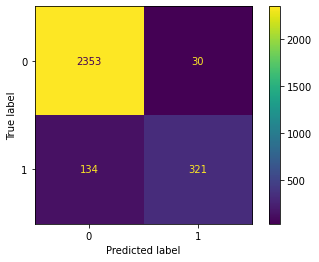

In [11]:
mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

y_hat = mnb.predict(X_train_vec)
accuracy_score(y_train, y_hat)
cm = confusion_matrix(y_train, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
accuracy_score(y_train, y_hat)

In [12]:
print(precision_score(y_train, y_hat))
print(recall_score(y_train, y_hat))
print(classification_report(y_train, y_hat))

0.9145299145299145
0.7054945054945055
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2383
         1.0       0.91      0.71      0.80       455

    accuracy                           0.94      2838
   macro avg       0.93      0.85      0.88      2838
weighted avg       0.94      0.94      0.94      2838



### NEURAL NETWORK MODEL USING KERAS

In [13]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [14]:
train_sequences = tokenizer.texts_to_sequences(X_train)
valid_sequences = tokenizer.texts_to_sequences(X_valid)

In [15]:
train_padded = pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')
valid_padded = pad_sequences(valid_sequences, maxlen=100, padding='post', truncating='post')

In [16]:
model = Sequential()
model.add(Embedding(5000, 16, input_length=100))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(train_padded, y_train, epochs=60, validation_data=(valid_padded, y_valid))

Epoch 1/60
89/89 [==============================] - 0s 2ms/step - loss: 0.5691 - accuracy: 0.8397 - val_loss: 0.4609 - val_accuracy: 0.8380
Epoch 2/60
89/89 [==============================] - 0s 947us/step - loss: 0.4403 - accuracy: 0.8397 - val_loss: 0.4390 - val_accuracy: 0.8380
Epoch 3/60
89/89 [==============================] - 0s 885us/step - loss: 0.4338 - accuracy: 0.8397 - val_loss: 0.4374 - val_accuracy: 0.8380
Epoch 4/60
89/89 [==============================] - 0s 952us/step - loss: 0.4310 - accuracy: 0.8397 - val_loss: 0.4353 - val_accuracy: 0.8380
Epoch 5/60
89/89 [==============================] - 0s 953us/step - loss: 0.4276 - accuracy: 0.8397 - val_loss: 0.4331 - val_accuracy: 0.8380
Epoch 6/60
89/89 [==============================] - 0s 908us/step - loss: 0.4234 - accuracy: 0.8397 - val_loss: 0.4313 - val_accuracy: 0.8380
Epoch 7/60
89/89 [==============================] - 0s 896us/step - loss: 0.4190 - accuracy: 0.8397 - val_loss: 0.4276 - val_accuracy: 0.8380
Epoch 8/

In [19]:
loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

23/23 [==============================] - 0s 520us/step - loss: 0.6129 - accuracy: 0.8732
Loss:  0.6129191517829895
Accuracy:  0.8732394576072693


### XGBOOST AND RANDOMFOREST MODELS

In [20]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [21]:
xgb.fit(X_train_vec, y_train)

[13:30:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [22]:
y_hat_xgb = xgb.predict(X_train_vec)

In [23]:
print("Accuracy: ", accuracy_score(y_train, y_hat_xgb))
print("Precision: ", precision_score(y_train, y_hat_xgb))
print("Recall: ", recall_score(y_train, y_hat_xgb))
print(classification_report(y_train, y_hat_xgb))

Accuracy:  0.9189570119802678
Precision:  0.9482071713147411
Recall:  0.5230769230769231
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2383
         1.0       0.95      0.52      0.67       455

    accuracy                           0.92      2838
   macro avg       0.93      0.76      0.81      2838
weighted avg       0.92      0.92      0.91      2838



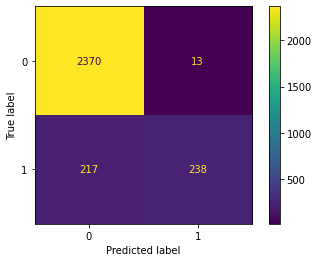

In [24]:
cm_xgb = confusion_matrix(y_train, y_hat_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()

In [25]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

In [26]:
rfc.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [27]:
y_pred_rfc = rfc.predict(X_valid_vec)

In [28]:
print("Accuracy: ", accuracy_score(y_valid, y_pred_rfc))
print("Precision: ", precision_score(y_valid, y_pred_rfc))
print("Recall: ", recall_score(y_valid, y_pred_rfc))
print(classification_report(y_valid, y_pred_rfc))

Accuracy:  0.8830985915492958
Precision:  0.9
Recall:  0.3130434782608696
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       595
         1.0       0.90      0.31      0.46       115

    accuracy                           0.88       710
   macro avg       0.89      0.65      0.70       710
weighted avg       0.88      0.88      0.86       710



# MULTICLASS CLASSIFIER

### MULTINOMIAL NAIVE BAYES MODEL

In [29]:
X = MultiClass_df_filtered['tweet_text'].astype(str)
y = MultiClass_df_filtered['target']

In [30]:
token_docs = [doc_preparer(doc, sw) for doc in X]

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(token_docs, y,
                                                    random_state=42,
                                                    test_size=0.20)

In [32]:
cv = CountVectorizer()

X_train_vec = cv.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_.keys())
X_train_vec.set_index(y_train.index, inplace=True)

X_valid_vec = cv.transform(X_valid)
X_valid_vec = pd.DataFrame.sparse.from_spmatrix(X_valid_vec)
X_valid_vec.columns = sorted(cv.vocabulary_.keys())
X_valid_vec.set_index(y_valid.index, inplace=True)

0.8080581980973699

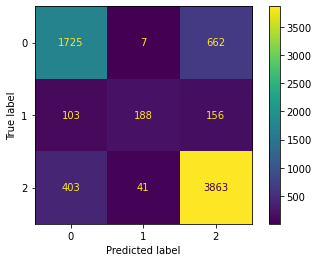

In [33]:
mnb = MultinomialNB()

mnb.fit(X_train_vec, y_train)

y_hat = mnb.predict(X_train_vec)
accuracy_score(y_train, y_hat)
cm = confusion_matrix(y_train, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
accuracy_score(y_train, y_hat)

In [34]:
print(precision_score(y_train, y_hat, average='micro'))
print(recall_score(y_train, y_hat, average='micro'))
print(classification_report(y_train, y_hat))

0.8080581980973699
0.8080581980973699
              precision    recall  f1-score   support

           0       0.77      0.72      0.75      2394
           1       0.80      0.42      0.55       447
           2       0.83      0.90      0.86      4307

    accuracy                           0.81      7148
   macro avg       0.80      0.68      0.72      7148
weighted avg       0.81      0.81      0.80      7148



### NEURAL NETWORK MODEL USING KERAS

In [35]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [36]:
train_sequences = tokenizer.texts_to_sequences(X_train)
valid_sequences = tokenizer.texts_to_sequences(X_valid)

In [37]:
train_padded = pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')
valid_padded = pad_sequences(valid_sequences, maxlen=100, padding='post', truncating='post')

In [38]:
num_classes = 3

In [39]:
model = Sequential()
model.add(Embedding(5000, 16, input_length=100))
model.add(GlobalAveragePooling1D())
model.add(Dense(12, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [40]:
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)

In [41]:
model.fit(train_padded, y_train_encoded, epochs=90, validation_data=(valid_padded, y_valid_encoded))

Epoch 1/90
224/224 [==============================] - 0s 1ms/step - loss: 0.9410 - accuracy: 0.5337 - val_loss: 0.8530 - val_accuracy: 0.6046
Epoch 2/90
224/224 [==============================] - 0s 793us/step - loss: 0.8418 - accuracy: 0.6025 - val_loss: 0.8501 - val_accuracy: 0.6046
Epoch 3/90
224/224 [==============================] - 0s 802us/step - loss: 0.8392 - accuracy: 0.6025 - val_loss: 0.8482 - val_accuracy: 0.6046
Epoch 4/90
224/224 [==============================] - 0s 810us/step - loss: 0.8357 - accuracy: 0.6025 - val_loss: 0.8453 - val_accuracy: 0.6046
Epoch 5/90
224/224 [==============================] - 0s 841us/step - loss: 0.8315 - accuracy: 0.6025 - val_loss: 0.8420 - val_accuracy: 0.6046
Epoch 6/90
224/224 [==============================] - 0s 846us/step - loss: 0.8260 - accuracy: 0.6025 - val_loss: 0.8386 - val_accuracy: 0.6046
Epoch 7/90
224/224 [==============================] - 0s 788us/step - loss: 0.8191 - accuracy: 0.6025 - val_loss: 0.8305 - val_accuracy: 0

In [42]:
loss, accuracy = model.evaluate(valid_padded, y_valid_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

 1/56 [..............................] - ETA: 0s - loss: 1.3416 - accuracy: 0.6250WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0010s). Check your callbacks.


56/56 [==============================] - 0s 427us/step - loss: 1.5375 - accuracy: 0.6628
Loss: 1.537500023841858
Accuracy: 0.6627516746520996


## XGBOOST

In [43]:
xgb = XGBClassifier()

In [44]:
xgb.fit(X_train_vec, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
y_train_pred_xgb = xgb.predict(X_train_vec)

In [46]:
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print(f'Training data accuracy: {train_accuracy_xgb * 100:.2f}%')

Training data accuracy: 79.78%


In [47]:
y_valid_pred_xgb = xgb.predict(X_valid_vec)

In [48]:
valid_accuracy_xgb = accuracy_score(y_valid, y_valid_pred_xgb)
print(f'Validation data accuracy: {valid_accuracy_xgb * 100:.2f}%')

Validation data accuracy: 69.13%


In [49]:
print("Training Data Metrics:")
print(classification_report(y_train, y_train_pred_xgb))

Training Data Metrics:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68      2394
           1       0.94      0.44      0.60       447
           2       0.77      0.97      0.86      4307

    accuracy                           0.80      7148
   macro avg       0.87      0.65      0.71      7148
weighted avg       0.82      0.80      0.78      7148



In [50]:
print("Validation Data Metrics:")
print(classification_report(y_valid, y_valid_pred_xgb))

Validation Data Metrics:
              precision    recall  f1-score   support

           0       0.67      0.42      0.52       584
           1       0.53      0.16      0.25       123
           2       0.70      0.90      0.79      1081

    accuracy                           0.69      1788
   macro avg       0.63      0.49      0.52      1788
weighted avg       0.68      0.69      0.66      1788

